In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from torch.utils.tensorboard import SummaryWriter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
def save_summary(writer, loss_dict, global_step, tag, lr=None, momentum=None):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)

### Training Arguments

In [2]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_sequence"
        self.batch_size = 4
        self.num_workers = 4
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 160
        self.log_freq = 8
        self.ckpt_freq_epoch = 20
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [3]:
setup_seed()
train_dataset = Kitti(data_root=args.data_root,
                        split='train')
val_dataset = Kitti(data_root=args.data_root,
                    split='val')
train_dataloader = get_dataloader(dataset=train_dataset, 
                                    batch_size=args.batch_size, 
                                    num_workers=args.num_workers,
                                    shuffle=True)
val_dataloader = get_dataloader(dataset=val_dataset, 
                                batch_size=args.batch_size, 
                                num_workers=args.num_workers,
                                shuffle=False)

### Model, Loss, Optimizer, Scheduler, Log

In [4]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses)

loss_func = Loss()

max_iters = 2*len(train_dataloader) * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)

saved_logs_path = os.path.join(args.saved_path, 'summary')
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

In [6]:
'''
for i, data_dict in enumerate(tqdm(train_dataloader)):
    if not args.no_cuda:
        # move the tensors to the cuda
        print("Here")
        for key in data_dict:
            for j, item in enumerate(data_dict[key]):
                if torch.is_tensor(item):
                    data_dict[key][j] = data_dict[key][j].cuda()
    
    optimizer.zero_grad()

    batched_pts = data_dict['batched_pts']
    batched_gt_bboxes = data_dict['batched_gt_bboxes']
    batched_labels = data_dict['batched_labels']
    batched_difficulty = data_dict['batched_difficulty']
    bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, \
        bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
            bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2, anchor_target_dict = \
                pointpillars(batched_pts=batched_pts, 
                                mode='train',
                                batched_gt_bboxes=batched_gt_bboxes, 
                                batched_gt_labels=batched_labels)
    
    break

'''

'\nfor i, data_dict in enumerate(tqdm(train_dataloader)):\n    if not args.no_cuda:\n        # move the tensors to the cuda\n        print("Here")\n        for key in data_dict:\n            for j, item in enumerate(data_dict[key]):\n                if torch.is_tensor(item):\n                    data_dict[key][j] = data_dict[key][j].cuda()\n    \n    optimizer.zero_grad()\n\n    batched_pts = data_dict[\'batched_pts\']\n    batched_gt_bboxes = data_dict[\'batched_gt_bboxes\']\n    batched_labels = data_dict[\'batched_labels\']\n    batched_difficulty = data_dict[\'batched_difficulty\']\n    bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0,         bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1,             bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2, anchor_target_dict =                 pointpillars(batched_pts=batched_pts, \n                                mode=\'train\',\n                                batched_gt_bboxes=batched_gt_bboxes, \n                                batched_g

### Training

In [5]:
training_loss0 = []
# training_loss1 = []
# training_loss2 = []

val_loss0 = []
# val_loss1 = []
# val_loss2 = []

==================== 0 ====================


  0%|          | 0/799 [00:00<?, ?it/s]

100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 1 ====================


100%|██████████| 720/720 [02:57<00:00,  4.05it/s]


==================== 2 ====================


100%|██████████| 799/799 [07:28<00:00,  1.78it/s]


==================== 3 ====================


100%|██████████| 720/720 [02:58<00:00,  4.03it/s]


==================== 4 ====================


100%|██████████| 799/799 [07:33<00:00,  1.76it/s]


==================== 5 ====================


100%|██████████| 720/720 [02:58<00:00,  4.03it/s]


==================== 6 ====================


100%|██████████| 799/799 [07:32<00:00,  1.77it/s]


==================== 7 ====================


100%|██████████| 720/720 [02:58<00:00,  4.04it/s]


==================== 8 ====================


100%|██████████| 799/799 [07:31<00:00,  1.77it/s]


==================== 9 ====================


100%|██████████| 720/720 [02:57<00:00,  4.06it/s]


==================== 10 ====================


100%|██████████| 799/799 [07:31<00:00,  1.77it/s]


==================== 11 ====================


100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 12 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


==================== 13 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 14 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 15 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 16 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 17 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 18 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 19 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


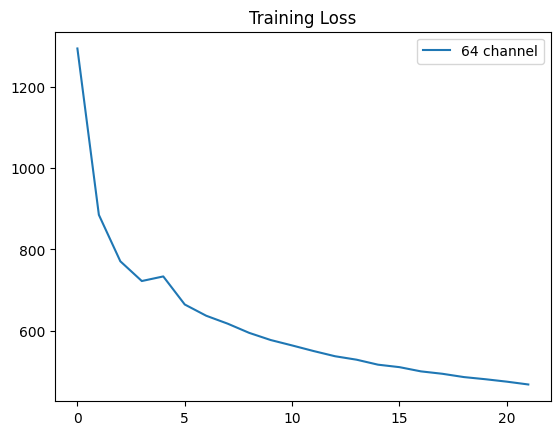

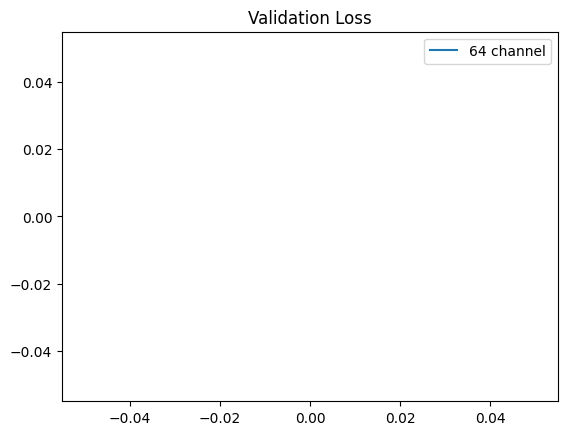

100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 20 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 21 ====================


100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 22 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


==================== 23 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 24 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 25 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 26 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 27 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 28 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 29 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 30 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 31 ====================


100%|██████████| 720/720 [02:53<00:00,  4.16it/s]


==================== 32 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 33 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 34 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 35 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 36 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 37 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 38 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 39 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


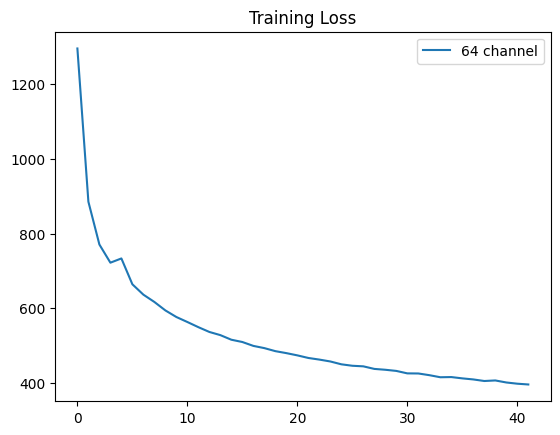

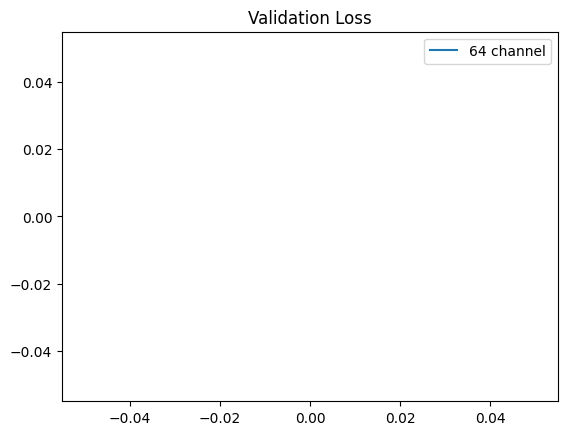

100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 40 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 41 ====================


100%|██████████| 720/720 [02:53<00:00,  4.16it/s]


==================== 42 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 43 ====================


100%|██████████| 720/720 [02:54<00:00,  4.12it/s]


==================== 44 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 45 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 46 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


==================== 47 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 48 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 49 ====================


100%|██████████| 720/720 [02:54<00:00,  4.14it/s]


==================== 50 ====================


100%|██████████| 799/799 [07:25<00:00,  1.79it/s]


==================== 51 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 52 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 53 ====================


100%|██████████| 720/720 [02:54<00:00,  4.12it/s]


==================== 54 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 55 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 56 ====================


100%|██████████| 799/799 [07:24<00:00,  1.80it/s]


==================== 57 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 58 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 59 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


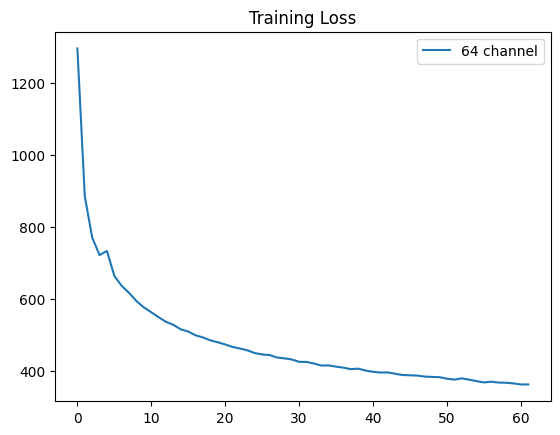

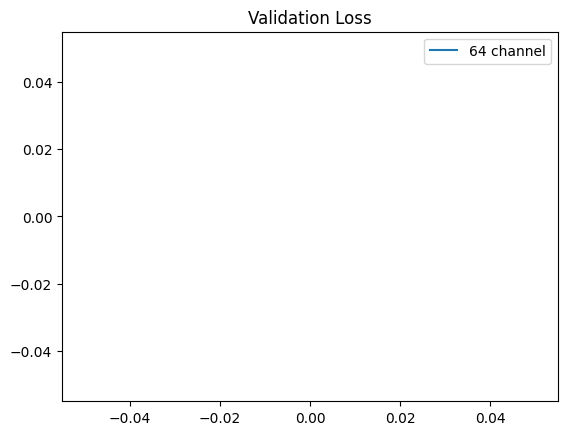

100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 60 ====================


100%|██████████| 799/799 [07:25<00:00,  1.79it/s]


==================== 61 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 62 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 63 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 64 ====================


100%|██████████| 799/799 [07:22<00:00,  1.80it/s]


==================== 65 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 66 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 67 ====================


100%|██████████| 720/720 [02:53<00:00,  4.16it/s]


==================== 68 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 69 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 70 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 71 ====================


100%|██████████| 720/720 [02:51<00:00,  4.20it/s]


==================== 72 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 73 ====================


100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 74 ====================


100%|██████████| 799/799 [07:22<00:00,  1.81it/s]


==================== 75 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 76 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 77 ====================


100%|██████████| 720/720 [02:53<00:00,  4.16it/s]


==================== 78 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 79 ====================


100%|██████████| 799/799 [07:18<00:00,  1.82it/s]


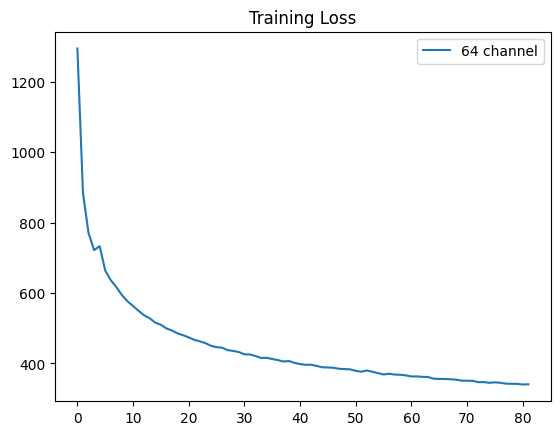

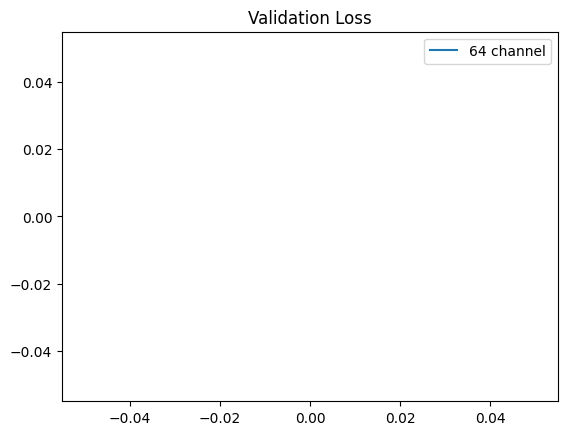

100%|██████████| 720/720 [02:51<00:00,  4.19it/s]


==================== 80 ====================


100%|██████████| 799/799 [07:22<00:00,  1.80it/s]


==================== 81 ====================


100%|██████████| 720/720 [02:51<00:00,  4.20it/s]


==================== 82 ====================


100%|██████████| 799/799 [07:18<00:00,  1.82it/s]


==================== 83 ====================


100%|██████████| 720/720 [02:54<00:00,  4.13it/s]


==================== 84 ====================


100%|██████████| 799/799 [07:22<00:00,  1.80it/s]


==================== 85 ====================


100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 86 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 87 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 88 ====================


100%|██████████| 799/799 [07:20<00:00,  1.82it/s]


==================== 89 ====================


100%|██████████| 720/720 [02:51<00:00,  4.20it/s]


==================== 90 ====================


100%|██████████| 799/799 [07:22<00:00,  1.80it/s]


==================== 91 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 92 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 93 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 94 ====================


100%|██████████| 799/799 [07:22<00:00,  1.80it/s]


==================== 95 ====================


100%|██████████| 720/720 [02:51<00:00,  4.19it/s]


==================== 96 ====================


100%|██████████| 799/799 [07:18<00:00,  1.82it/s]


==================== 97 ====================


100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 98 ====================


100%|██████████| 799/799 [07:21<00:00,  1.81it/s]


==================== 99 ====================


100%|██████████| 799/799 [07:18<00:00,  1.82it/s]


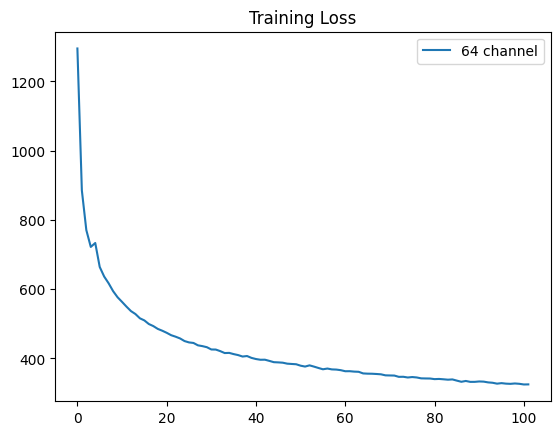

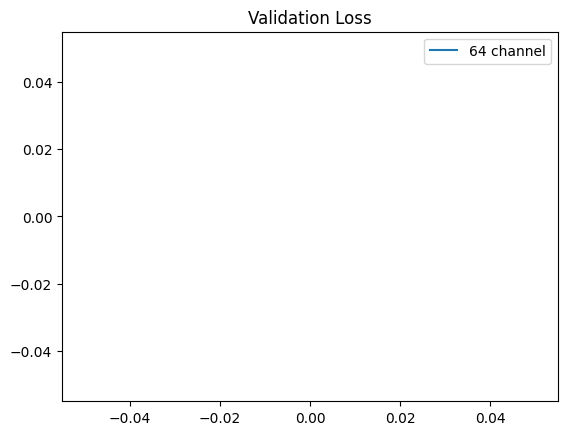

100%|██████████| 720/720 [02:52<00:00,  4.18it/s]


==================== 100 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 101 ====================


100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


==================== 102 ====================


100%|██████████| 799/799 [07:20<00:00,  1.81it/s]


==================== 103 ====================


100%|██████████| 720/720 [02:52<00:00,  4.17it/s]


==================== 104 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 105 ====================


100%|██████████| 720/720 [02:51<00:00,  4.19it/s]


==================== 106 ====================


100%|██████████| 799/799 [07:18<00:00,  1.82it/s]


==================== 107 ====================


100%|██████████| 720/720 [02:53<00:00,  4.16it/s]


==================== 108 ====================


100%|██████████| 799/799 [07:25<00:00,  1.80it/s]


==================== 109 ====================


100%|██████████| 720/720 [02:50<00:00,  4.21it/s]


==================== 110 ====================


100%|██████████| 799/799 [07:22<00:00,  1.81it/s]


==================== 111 ====================


100%|██████████| 720/720 [02:52<00:00,  4.16it/s]


==================== 112 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 113 ====================


100%|██████████| 720/720 [02:51<00:00,  4.19it/s]


==================== 114 ====================


100%|██████████| 799/799 [07:23<00:00,  1.80it/s]


==================== 115 ====================


100%|██████████| 720/720 [02:53<00:00,  4.15it/s]


==================== 116 ====================


100%|██████████| 799/799 [07:19<00:00,  1.82it/s]


==================== 117 ====================


100%|██████████| 720/720 [02:58<00:00,  4.03it/s]


==================== 118 ====================


100%|██████████| 799/799 [07:30<00:00,  1.77it/s]


==================== 119 ====================


100%|██████████| 799/799 [07:27<00:00,  1.79it/s]


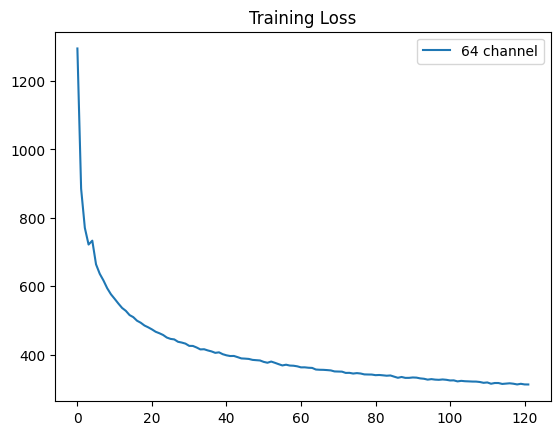

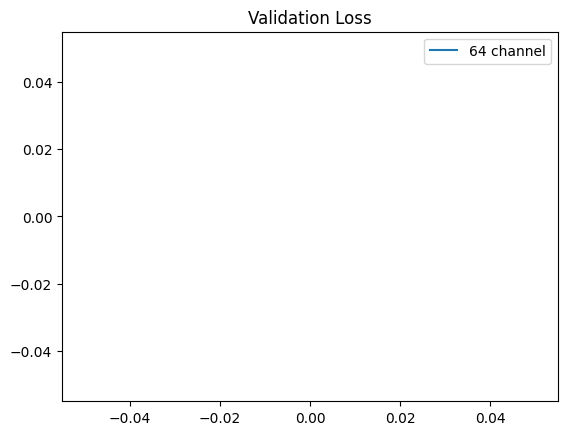

100%|██████████| 720/720 [02:41<00:00,  4.47it/s]


==================== 120 ====================


100%|██████████| 799/799 [06:53<00:00,  1.93it/s]


==================== 121 ====================


100%|██████████| 720/720 [02:41<00:00,  4.46it/s]


==================== 122 ====================


100%|██████████| 799/799 [06:51<00:00,  1.94it/s]


==================== 123 ====================


100%|██████████| 720/720 [02:40<00:00,  4.47it/s]


==================== 124 ====================


100%|██████████| 799/799 [06:51<00:00,  1.94it/s]


==================== 125 ====================


100%|██████████| 720/720 [02:41<00:00,  4.45it/s]


==================== 126 ====================


100%|██████████| 799/799 [06:53<00:00,  1.93it/s]


==================== 127 ====================


100%|██████████| 720/720 [02:41<00:00,  4.45it/s]


==================== 128 ====================


100%|██████████| 799/799 [06:54<00:00,  1.93it/s]


==================== 129 ====================


100%|██████████| 720/720 [02:44<00:00,  4.39it/s]


==================== 130 ====================


100%|██████████| 799/799 [06:52<00:00,  1.94it/s]


==================== 131 ====================


100%|██████████| 720/720 [02:42<00:00,  4.44it/s]


==================== 132 ====================


100%|██████████| 799/799 [06:52<00:00,  1.94it/s]


==================== 133 ====================


100%|██████████| 720/720 [02:40<00:00,  4.47it/s]


==================== 134 ====================


100%|██████████| 799/799 [06:51<00:00,  1.94it/s]


==================== 135 ====================


100%|██████████| 720/720 [02:41<00:00,  4.47it/s]


==================== 136 ====================


100%|██████████| 799/799 [06:51<00:00,  1.94it/s]


==================== 137 ====================


100%|██████████| 720/720 [02:40<00:00,  4.48it/s]


==================== 138 ====================


100%|██████████| 799/799 [06:57<00:00,  1.91it/s]


==================== 139 ====================


100%|██████████| 799/799 [07:01<00:00,  1.90it/s]


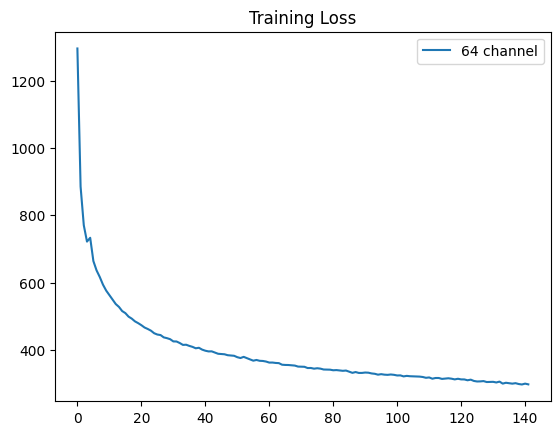

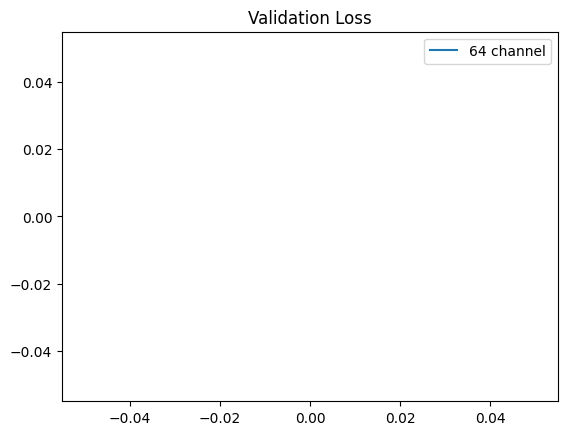

 13%|█▎        | 97/720 [00:23<02:30,  4.15it/s]

In [10]:
for epoch in range(args.max_epoch):
# for epoch in range(args.max_epoch):
    epoch_loss0 = 0
    # epoch_loss1 = 0
    # epoch_loss2 = 0

    val_epoch_loss0 = 0
    # val_epoch_loss1 = 0
    # val_epoch_loss2 = 0

    print('=' * 20, epoch, '=' * 20)
    train_step, val_step = 0, 0
    for i, data_dict in enumerate(tqdm(train_dataloader)):
        if not args.no_cuda:
            # move the tensors to the cuda
            for key in data_dict:
                for j, item in enumerate(data_dict[key]):
                    if torch.is_tensor(item):
                        data_dict[key][j] = data_dict[key][j].cuda()
        
        optimizer.zero_grad()

        batched_pts = data_dict['batched_pts']
        batched_gt_bboxes = data_dict['batched_gt_bboxes']
        batched_labels = data_dict['batched_labels']
        batched_difficulty = data_dict['batched_difficulty']


        bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
                                    mode='train',
                                    batched_gt_bboxes=batched_gt_bboxes, 
                                    batched_gt_labels=batched_labels)#\
            # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
            #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

        
        ################# Full features #################
        bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
        bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

        # ################# Half features #################
        # bbox_cls_pred1 = bbox_cls_pred1.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        # bbox_pred1 = bbox_pred1.permute(0, 2, 3, 1).reshape(-1, 7)
        # bbox_dir_cls_pred1 = bbox_dir_cls_pred1.permute(0, 2, 3, 1).reshape(-1, 2)

        # ################# Quar features #################
        # bbox_cls_pred2 = bbox_cls_pred2.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        # bbox_pred2 = bbox_pred2.permute(0, 2, 3, 1).reshape(-1, 7)
        # bbox_dir_cls_pred2 = bbox_dir_cls_pred2.permute(0, 2, 3, 1).reshape(-1, 2)


        batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
        batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
        batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
        batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


        
        pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

        bbox_pred0 = bbox_pred0[pos_idx]
        # bbox_pred1 = bbox_pred1[pos_idx]
        # bbox_pred2 = bbox_pred2[pos_idx]

        batched_bbox_reg = batched_bbox_reg[pos_idx]
        batched_bbox_reg0 = batched_bbox_reg.clone()
        # batched_bbox_reg1 = batched_bbox_reg.clone()
        # batched_bbox_reg2 = batched_bbox_reg.clone()

        # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
        bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
        # bbox_pred1[:, -1] = torch.sin(bbox_pred1[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
        # bbox_pred2[:, -1] = torch.sin(bbox_pred2[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())

        batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
        # batched_bbox_reg1[:, -1] = torch.cos(bbox_pred1[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
        # batched_bbox_reg2[:, -1] = torch.cos(bbox_pred2[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())


        bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
        # bbox_dir_cls_pred1 = bbox_dir_cls_pred1[pos_idx]
        # bbox_dir_cls_pred2 = bbox_dir_cls_pred2[pos_idx]

        batched_dir_labels = batched_dir_labels[pos_idx]

        num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

        bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]
        # bbox_cls_pred1 = bbox_cls_pred1[batched_label_weights > 0]
        # bbox_cls_pred2 = bbox_cls_pred2[batched_label_weights > 0]

        batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
        batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

        loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                bbox_pred=bbox_pred0,
                                bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                batched_labels=batched_bbox_labels, 
                                num_cls_pos=num_cls_pos, 
                                batched_bbox_reg=batched_bbox_reg0, 
                                batched_dir_labels=batched_dir_labels)
        
        # loss_dict1 = loss_func(bbox_cls_pred=bbox_cls_pred1,
        #                         bbox_pred=bbox_pred1,
        #                         bbox_dir_cls_pred=bbox_dir_cls_pred1,
        #                         batched_labels=batched_bbox_labels, 
        #                         num_cls_pos=num_cls_pos, 
        #                         batched_bbox_reg=batched_bbox_reg1, 
        #                         batched_dir_labels=batched_dir_labels)
        
        # loss_dict2 = loss_func(bbox_cls_pred=bbox_cls_pred2,
        #                         bbox_pred=bbox_pred2,
        #                         bbox_dir_cls_pred=bbox_dir_cls_pred2,
        #                         batched_labels=batched_bbox_labels, 
        #                         num_cls_pos=num_cls_pos, 
        #                         batched_bbox_reg=batched_bbox_reg2, 
        #                         batched_dir_labels=batched_dir_labels)
        
        loss0 = loss_dict0['total_loss'] 
        # loss1 = loss_dict1['total_loss']
        # loss2 = loss_dict2['total_loss'] 
        loss = loss0 # + loss1 + loss2
        loss.backward()

        epoch_loss0 = epoch_loss0 + loss0.item()
        # epoch_loss1 = epoch_loss1 + loss1.item()
        # epoch_loss2 = epoch_loss2 + loss2.item()

        # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
        optimizer.step()
        scheduler.step()



        global_step = epoch * len(train_dataloader) + train_step + 1

        if global_step % args.log_freq == 0:
            save_summary(writer, loss_dict0, global_step, 'train',
                            lr=optimizer.param_groups[0]['lr'], 
                            momentum=optimizer.param_groups[0]['betas'][0])
        train_step += 1

    training_loss0.append(epoch_loss0)
    # training_loss1.append(epoch_loss1)
    # training_loss2.append(epoch_loss2)

    if (epoch + 1) % args.ckpt_freq_epoch == 0:
        torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))

        plt.figure()
        plt.plot(np.array(training_loss0))
        # plt.plot(np.array(training_loss1))
        # plt.plot(np.array(training_loss2))
        plt.title("Training Loss")
        plt.legend(["64 channel","32 channel","16 channel"])
        plt.show()

        plt.figure()
        plt.plot(np.array(val_loss0))
        # plt.plot(np.array(val_loss1))
        # plt.plot(np.array(val_loss2))
        plt.title("Validation Loss")
        plt.legend(["64 channel","32 channel","16 channel"])
        plt.show()

    if epoch % 2 == 0:
        continue
    pointpillars.eval()
    with torch.no_grad():
        for i, data_dict in enumerate(tqdm(val_dataloader)):
            try:
                if not args.no_cuda:
                    # move the tensors to the cuda
                    for key in data_dict:
                        for j, item in enumerate(data_dict[key]):
                            if torch.is_tensor(item):
                                data_dict[key][j] = data_dict[key][j].cuda()
                
                batched_pts = data_dict['batched_pts']
                batched_gt_bboxes = data_dict['batched_gt_bboxes']
                batched_labels = data_dict['batched_labels']
                batched_difficulty = data_dict['batched_difficulty']

                bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
                                            mode='train',
                                            batched_gt_bboxes=batched_gt_bboxes, 
                                            batched_gt_labels=batched_labels)\
                    # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
                    #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

                
                ################# Full features #################
                bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
                bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
                bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

                ################# Half features #################
                # bbox_cls_pred1 = bbox_cls_pred1.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
                # bbox_pred1 = bbox_pred1.permute(0, 2, 3, 1).reshape(-1, 7)
                # bbox_dir_cls_pred1 = bbox_dir_cls_pred1.permute(0, 2, 3, 1).reshape(-1, 2)

                # ################# Quar features #################
                # bbox_cls_pred2 = bbox_cls_pred2.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
                # bbox_pred2 = bbox_pred2.permute(0, 2, 3, 1).reshape(-1, 7)
                # bbox_dir_cls_pred2 = bbox_dir_cls_pred2.permute(0, 2, 3, 1).reshape(-1, 2)


                batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
                batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
                batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
                batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
                pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

                bbox_pred0 = bbox_pred0[pos_idx]
                # bbox_pred1 = bbox_pred1[pos_idx]
                # bbox_pred2 = bbox_pred2[pos_idx]

                batched_bbox_reg = batched_bbox_reg[pos_idx]
                batched_bbox_reg0 = batched_bbox_reg.clone()
                # batched_bbox_reg1 = batched_bbox_reg.clone()
                # batched_bbox_reg2 = batched_bbox_reg.clone()

                # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
                bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
                # bbox_pred1[:, -1] = torch.sin(bbox_pred1[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
                # bbox_pred2[:, -1] = torch.sin(bbox_pred2[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())

                batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
                # batched_bbox_reg1[:, -1] = torch.cos(bbox_pred1[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
                # batched_bbox_reg2[:, -1] = torch.cos(bbox_pred2[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())


                bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
                # bbox_dir_cls_pred1 = bbox_dir_cls_pred1[pos_idx]
                # bbox_dir_cls_pred2 = bbox_dir_cls_pred2[pos_idx]

                batched_dir_labels = batched_dir_labels[pos_idx]

                num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

                bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]
                # bbox_cls_pred1 = bbox_cls_pred1[batched_label_weights > 0]
                # bbox_cls_pred2 = bbox_cls_pred2[batched_label_weights > 0]

                batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
                batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

                loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                        bbox_pred=bbox_pred0,
                                        bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                        batched_labels=batched_bbox_labels, 
                                        num_cls_pos=num_cls_pos, 
                                        batched_bbox_reg=batched_bbox_reg0, 
                                        batched_dir_labels=batched_dir_labels)
                
                # loss_dict1 = loss_func(bbox_cls_pred=bbox_cls_pred1,
                #                         bbox_pred=bbox_pred1,
                #                         bbox_dir_cls_pred=bbox_dir_cls_pred1,
                #                         batched_labels=batched_bbox_labels, 
                #                         num_cls_pos=num_cls_pos, 
                #                         batched_bbox_reg=batched_bbox_reg1, 
                #                         batched_dir_labels=batched_dir_labels)
                
                # loss_dict2 = loss_func(bbox_cls_pred=bbox_cls_pred2,
                #                         bbox_pred=bbox_pred2,
                #                         bbox_dir_cls_pred=bbox_dir_cls_pred2,
                #                         batched_labels=batched_bbox_labels, 
                #                         num_cls_pos=num_cls_pos, 
                #                         batched_bbox_reg=batched_bbox_reg2, 
                #                         batched_dir_labels=batched_dir_labels)
                
                loss0 = loss_dict0['total_loss'] 
                # loss1 = loss_dict1['total_loss']
                # loss2 = loss_dict2['total_loss'] 

                val_epoch_loss0 = val_epoch_loss0 + loss0.item()
                # val_epoch_loss1 = val_epoch_loss1 + loss1.item()
                # val_epoch_loss2 = val_epoch_loss2 + loss2.item()

                global_step = epoch * len(val_dataloader) + val_step + 1
                if global_step % args.log_freq == 0:
                    save_summary(writer, loss_dict0, global_step, 'val')
                val_step += 1
            
            except:
                None

    val_loss0.append(val_epoch_loss0)
    # val_loss1.append(val_epoch_loss1)
    # val_loss2.append(val_epoch_loss2)
            
    pointpillars.train()


In [ ]:
plt.figure()
plt.plot(np.array(training_loss0))
# plt.plot(np.array(training_loss1))
# plt.plot(np.array(training_loss2))
plt.title("Training Loss")
plt.legend(["64 channel","32 channel","16 channel"])
plt.savefig("Matryoshka_train_loss.png")
plt.show()

plt.figure()
plt.plot(np.array(val_loss0))
# plt.plot(np.array(val_loss1))
# plt.plot(np.array(val_loss2))
plt.title("Validation Loss")
plt.legend(["64 channel","32 channel","16 channel"])
plt.savefig("Matryoshka_val_loss.png")
plt.show()